# Подготовка данных

In [22]:
! pip install numpy librosa tqdm matplotlib pypinyin torch==2.8.0 torchaudio==2.8.0 funasr==1.1.9

  Using cached torchaudio-2.8.0-cp312-cp312-win_amd64.whl.metadata (7.2 kB)
Using cached torchaudio-2.8.0-cp312-cp312-win_amd64.whl (2.5 MB)


In [23]:
import os
import urllib
import shutil
import tarfile
import numpy as np
import librosa
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from pypinyin import pinyin, Style
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from funasr import AutoModel

Notice: ffmpeg is not installed. torchaudio is used to load audio
If you want to use ffmpeg backend to load audio, please install it by:
	sudo apt install ffmpeg # ubuntu
	# brew install ffmpeg # mac


In [3]:
PROJECT_ROOT = Path(".").parent
DATA_DIR = PROJECT_ROOT / "data" / "aishell3"
PROCESSED_DIR = PROJECT_ROOT / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

In [13]:
AISHELL3_URL = "http://www.openslr.org/resources/93/data_aishell3.tgz"

In [14]:
def download_aishell3():
    """Скачивает AISHELL-3, если ещё не скачан"""
    tar_path = DATA_DIR / "data_aishell3.tgz"
    if tar_path.exists():
        print("AISHELL-3 архив уже скачан")
        return tar_path

    print("Скачивание AISHELL-3")
    def reporthook(block_num, block_size, total_size):
        if total_size > 0:
            percent = min(100, (block_num * block_size * 100) // total_size)
            print(f"\rПрогресс: {percent}%", end="")
    urllib.request.urlretrieve(AISHELL3_URL, tar_path, reporthook)
    print("\nЗагрузка завершена")
    
    return tar_path

In [15]:
def extract_aishell3(tar_path: Path):
    """Распаковывает AISHELL-3"""
    if (DATA_DIR / "train").exists() and (DATA_DIR / "test").exists():
        print("AISHELL-3 уже распакован")
        return

    print("Распаковка")
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(DATA_DIR.parent)

    src_dir = DATA_DIR.parent / "data_aishell3"
    if src_dir.exists():
        for item in src_dir.iterdir():
            shutil.move(str(item), str(DATA_DIR))
        shutil.rmtree(src_dir)
    print("Распаковка завершена")

In [16]:
def load_content_labels():
    content_path = DATA_DIR / "train" / "content.txt"
    labels = {}
    with open(content_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            
            if not parts:
                continue
            
            wav_id = parts[0].replace(".wav", "")
            for i, p in enumerate(parts[1:], 1):
                if p[-1].isdigit() and p[:-1].isalpha():
                    syllables = parts[i:]
                    labels[wav_id] = syllables
                    break
                
    return labels

In [21]:
def process_wav_file(wav_id, syllables):
    """Оптимизированная обработка одного WAV-файла:
        - Загрузка 1 раз
        - Нормализация по диктору (глобальная для файла)
        - Быстрый фильтр по амплитуде
    """
    speaker = wav_id[:7]
    wav_path = DATA_DIR / "train" / "wav" / speaker / f"{wav_id}.wav"
    if not wav_path.exists():
        return []

    # Загружаем ОДИН раз
    y, sr = librosa.load(wav_path, sr=16000)
    if len(y) == 0:
        return []

    # Сохраняем исходную амплитуду для фильтрации
    max_amp = np.max(np.abs(y))
    if max_amp == 0:
        return []
    
    # Нормализуем для стабильности
    y_norm = y / max_amp

    duration = len(y) / sr
    n_syl = len(syllables)
    results = []

    for i, syl in enumerate(syllables):
        start = i * duration / n_syl
        end = (i + 1) * duration / n_syl
        start_idx = int(start * sr)
        end_idx = int(end * sr)
        y_seg = y_norm[start_idx:end_idx]

        if len(y_seg) == 0:
            continue

        # пропускаем тихие сегменты
        seg_max = np.max(np.abs(y_seg))
        if seg_max < 0.05:  # 5% от максимума диктора
            continue

        # уменьшенные параметры для скорости
        f0, _, _ = librosa.pyin(
            y_seg,
            fmin=librosa.note_to_hz('C2'),   # ~65 Гц
            fmax=librosa.note_to_hz('C7'),   # ~2093 Гц
            sr=sr,
            frame_length=512,
            hop_length=128
        )
        f0 = f0[~np.isnan(f0)]
        if len(f0) < 5:
            continue

        tone = int(syl[-1]) if syl[-1].isdigit() else 5
        results.append((f0.astype(np.float32), tone))

    return results

In [22]:
for fname in ["f0_raw.npy", "tones.npy"]:
    fpath = PROCESSED_DIR / fname
    if fpath.exists():
        fpath.unlink()
        print(f"Удалён старый файл: {fpath}")

Удалён старый файл: processed\f0_raw.npy
Удалён старый файл: processed\tones.npy


In [23]:
# Загрузка и обработка
labels = load_content_labels()
all_f0, all_tones = [], []

print("Обработка файлов")
for wav_id, syllables in tqdm(list(labels.items())[:1000]):
    results = process_wav_file(wav_id, syllables)
    all_f0.extend(f for f, _ in results)
    all_tones.extend(t for _, t in results)

# Сохранение
np.save(PROCESSED_DIR / "f0_raw.npy", np.array(all_f0, dtype=object), allow_pickle=True)
np.save(PROCESSED_DIR / "tones.npy", np.array(all_tones))
print(f"Обработано {len(all_f0)} слогов")

Обработка файлов


100%|██████████| 1000/1000 [1:21:03<00:00,  4.86s/it]

Обработано 15743 слогов


# Диагностика данных

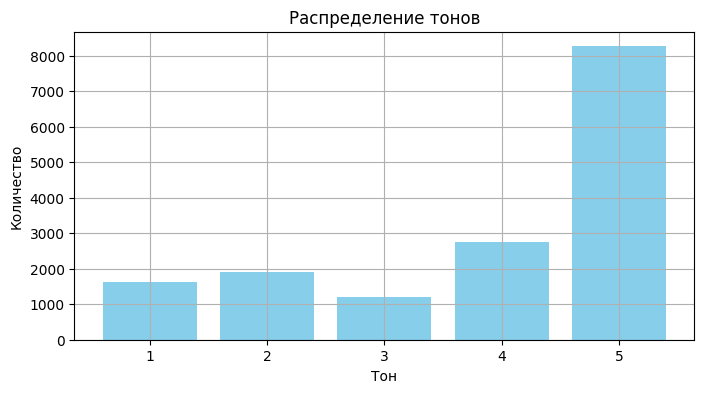

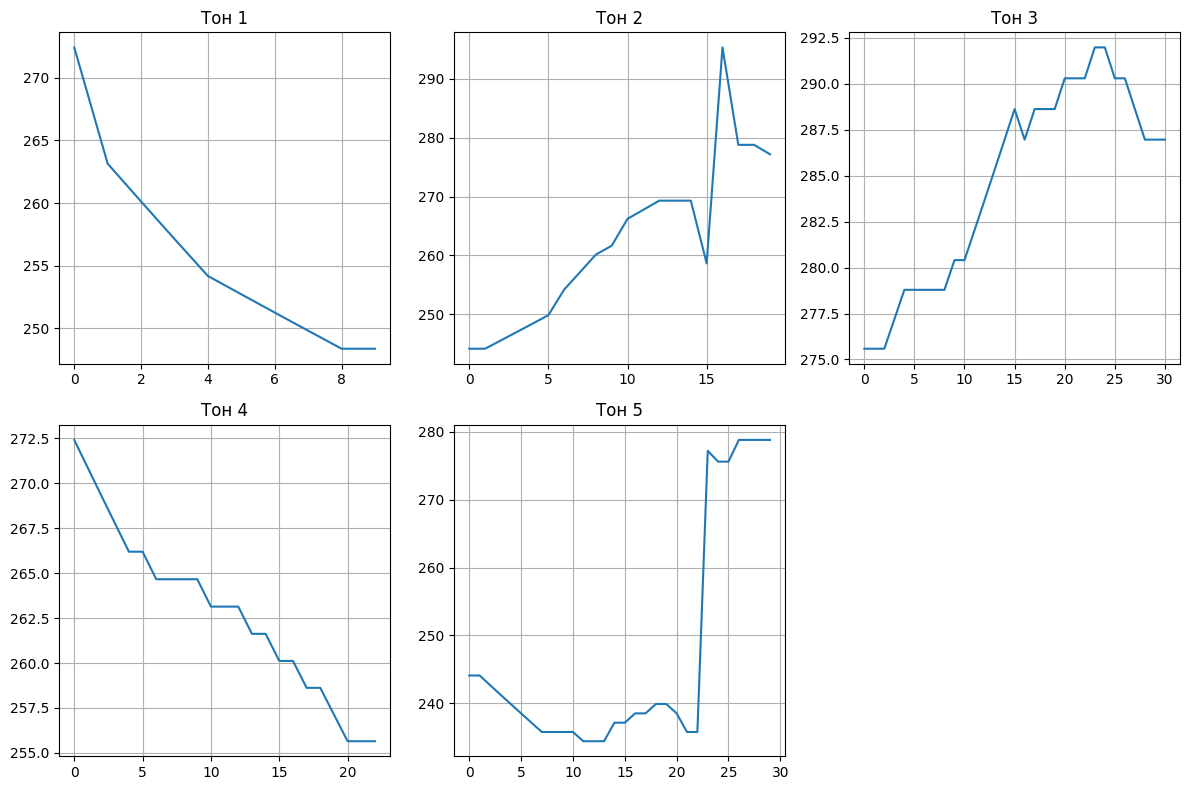

In [7]:
# Загрузка
f0_raw = np.load(PROCESSED_DIR / "f0_raw.npy", allow_pickle=True)
tones = np.load(PROCESSED_DIR / "tones.npy")

# Распределение тонов
plt.figure(figsize=(8, 4))
plt.hist(tones, bins=np.arange(0.5, 6.5, 1), rwidth=0.8, color='skyblue')
plt.xticks([1,2,3,4,5])
plt.title("Распределение тонов")
plt.xlabel("Тон")
plt.ylabel("Количество")
plt.grid(True)
plt.show()

# Примеры F0-контуров
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flat
for tone in range(1, 6):
    idxs = np.where(tones == tone)[0]
    if len(idxs) == 0:
        continue
    ax = axes[tone - 1]
    ax.plot(f0_raw[idxs[0]], color='C0')
    ax.set_title(f"Тон {tone}")
    ax.grid(True)
axes[5].set_visible(False)
plt.tight_layout()
plt.show()

# Подготовка данных для обучения

In [8]:
# Преобразуем в лог-шкалу и нормализуем
def preprocess_f0(f0):
    log_f0 = np.log(f0[f0 > 0])
    if len(log_f0) < 2:
        return None
    x_old = np.linspace(0, 1, len(log_f0))
    x_new = np.linspace(0, 1, 50)
    f0_interp = np.interp(x_new, x_old, log_f0)
    f0_norm = (f0_interp - f0_interp.mean()) / (f0_interp.std() + 1e-8)
    return f0_norm

X_cnn, X_mlp, y = [], [], []
for f0, tone in zip(f0_raw, tones):
    norm_f0 = preprocess_f0(f0)
    if norm_f0 is None:
        continue
    X_cnn.append(norm_f0)
    
    # MLP features
    log_f0 = np.log(f0[f0 > 0])
    x = np.linspace(0, 1, len(log_f0))
    coeffs = np.polyfit(x, log_f0, deg=2)
    a, b = coeffs[0], coeffs[1]
    std_val = np.std(log_f0)
    slope = log_f0[-1] - log_f0[0]
    X_mlp.append([a, b, slope, std_val])
    y.append(tone - 1)  # 0-4

X_cnn = np.array(X_cnn, dtype=np.float32)
X_mlp = np.array(X_mlp, dtype=np.float32)
y = np.array(y)

print(f"Данные для CNN: {X_cnn.shape}")
print(f"Данные для MLP: {X_mlp.shape}")
print(f"Метки: {y.shape}")

Данные для CNN: (15743, 50)
Данные для MLP: (15743, 4)
Метки: (15743,)


# Обучение CNN

In [9]:
# Деление
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_cnn, y, test_size=0.2, random_state=42, stratify=y)

# Веса классов
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_cnn), y=y_train_cnn)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Датасеты
train_ds = TensorDataset(torch.from_numpy(X_train_cnn), torch.from_numpy(y_train_cnn))
val_ds = TensorDataset(torch.from_numpy(X_val_cnn), torch.from_numpy(y_val_cnn))
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128)

In [12]:
class ToneCNN(nn.Module):
    def __init__(self, input_len=50, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten()
        )
        # Вычисляем выходную длину после свёрток и пулингов
        self.fc_input = 64 * (input_len // 4)
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, L) -> (B, 1, L)
        x = self.features(x)
        x = self.classifier(x)
        return x


class ToneCNNTrainer:
    def __init__(self, model, device, class_weights=None, lr=0.001, patience=5, model_path="cnn_model.pth"):
        self.device = device
        self.model = model.to(device)
        self.class_weights = class_weights.to(device) if class_weights is not None else None
        self.criterion = nn.CrossEntropyLoss(weight=self.class_weights)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.patience = patience
        self.model_path = Path(model_path)
        self.best_val_acc = 0.0
        self.epochs_without_improvement = 0

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(x), y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def validate(self, val_loader):
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(self.device), y.to(self.device)
                pred = self.model(x).argmax(dim=1)
                total += y.size(0)
                correct += (pred == y).sum().item()
        return correct / total

    def train(self, train_loader, val_loader, num_epochs=50):
        print(f"Начало обучения (макс. {num_epochs} эпох, ранняя остановка через {self.patience} эпох без улучшения)")

        for epoch in range(1, num_epochs + 1):
            train_loss = self.train_epoch(train_loader)
            val_acc = self.validate(val_loader)

            # Вывод каждые 5 эпох или последнюю
            if epoch % 5 == 0 or epoch == num_epochs:
                print(f"Epoch {epoch:02d}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

            # Ранняя остановка
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.epochs_without_improvement = 0
                # Сохраняем лучшую модель
                torch.save(self.model.state_dict(), self.model_path)
                print(f"Сохранена лучшая модель (Val Acc: {val_acc:.4f})")
            else:
                self.epochs_without_improvement += 1
                if self.epochs_without_improvement >= self.patience:
                    print(f"Ранняя остановка на эпохе {epoch} (лучшая точность: {self.best_val_acc:.4f})")
                    break

        print(f"Обучение завершено. Лучшая валидационная точность: {self.best_val_acc:.4f}")
        # Загружаем лучшую модель
        self.model.load_state_dict(torch.load(self.model_path))

In [18]:
# Инициализация
device = torch.device("cpu")
cnn = ToneCNN(input_len=50, num_classes=5)
trainer = ToneCNNTrainer(
    model=cnn,
    device=device,
    class_weights=class_weights,
    lr=0.001,
    patience=15,
    model_path="models/cnn_best.pth"
)

# Запуск обучения
trainer.train(train_dl, val_dl, num_epochs=50)

Начало обучения (макс. 50 эпох, ранняя остановка через 15 эпох без улучшения)
Сохранена лучшая модель (Val Acc: 0.1823)
Сохранена лучшая модель (Val Acc: 0.1839)
Epoch 05/50 | Train Loss: 1.5902 | Val Acc: 0.1785
Сохранена лучшая модель (Val Acc: 0.1924)
Epoch 10/50 | Train Loss: 1.5698 | Val Acc: 0.1842
Epoch 15/50 | Train Loss: 1.5457 | Val Acc: 0.1756
Epoch 20/50 | Train Loss: 1.5126 | Val Acc: 0.1702
Ранняя остановка на эпохе 24 (лучшая точность: 0.1924)
Обучение завершено. Лучшая валидационная точность: 0.1924


# Обучение MLP

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

mlp = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
mlp.fit(X_mlp, y)

X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(X_mlp, y, test_size=0.2, random_state=42, stratify=y)
y_pred_mlp = mlp.predict(X_val_mlp)
print(f"MLP Val Acc: {accuracy_score(y_val_mlp, y_pred_mlp):.4f}")

MLP Val Acc: 0.9978


# Тестирование 

Эталон: 1-й тон
CNN: 4-й тон → нужно: 1-й
MLP: 1-й тон → верно


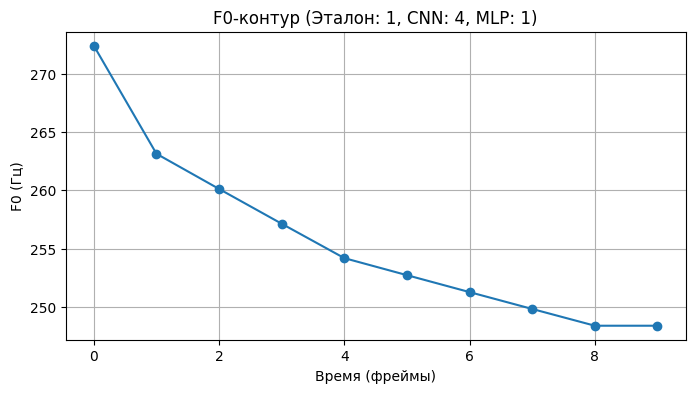

In [19]:
def predict_and_feedback(f0_hz, true_tone, model_type="cnn"):
    log_f0 = np.log(f0_hz[f0_hz > 0])

    if len(log_f0) < 2:
        return 5
    
    x_old = np.linspace(0, 1, len(log_f0))
    x_new = np.linspace(0, 1, 50)
    f0_interp = np.interp(x_new, x_old, log_f0)
    f0_norm = (f0_interp - f0_interp.mean()) / (f0_interp.std() + 1e-8)
    
    if model_type == "cnn":
        x_tensor = torch.tensor(f0_norm, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = cnn(x_tensor).argmax(dim=1).item()
        return pred + 1
    else:
        coeffs = np.polyfit(x_old, log_f0, deg=2)
        a, b = coeffs[0], coeffs[1]
        std_val = np.std(log_f0)
        slope = log_f0[-1] - log_f0[0]
        features = np.array([[a, b, slope, std_val]])
        return mlp.predict(features)[0] + 1

# Пример
idx = 0
f0_example = f0_raw[idx]
true_tone = tones[idx]
pred_cnn = predict_and_feedback(f0_example, true_tone, "cnn")
pred_mlp = predict_and_feedback(f0_example, true_tone, "mlp")

print(f"Эталон: {true_tone}-й тон")
print(f"CNN: {pred_cnn}-й тон → {'верно' if pred_cnn == true_tone else f'нужно: {true_tone}-й'}")
print(f"MLP: {pred_mlp}-й тон → {'верно' if pred_mlp == true_tone else f'нужно: {true_tone}-й'}")

# График
plt.figure(figsize=(8, 4))
plt.plot(f0_example, marker='o')
plt.title(f"F0-контур (Эталон: {true_tone}, CNN: {pred_cnn}, MLP: {pred_mlp})")
plt.xlabel("Время (фреймы)")
plt.ylabel("F0 (Гц)")
plt.grid(True)
plt.show()